In [1]:
import cv2
import numpy as np
from pandas import DataFrame, read_csv
from matplotlib import pyplot as plt
from shutil import copy2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten,
                                     GlobalMaxPooling2D, LeakyReLU, concatenate, Dropout)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam, Adamax
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from os.path import isfile

In [2]:
SEED = 42
from numpy.random import seed
from tensorflow import random
seed(SEED)
random.set_seed(SEED)

In [3]:
y_filename='training_solutions_rev1.csv'
y = read_csv(y_filename, index_col=0)[['Class1.1','Class1.2','Class1.3']]

In [4]:
crop_shape = (256,256)
input_shape = (96,96)

In [5]:
def create_model(input_shape=(input_shape[0],input_shape[1],3)):
    return Sequential([
        Input(shape=input_shape),
        
        Conv2D(8,(3,3), padding='same', input_shape=input_shape),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(16,(3,3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(8,(3,3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        #Conv2D(4,(3,3), padding='same'),
        #Activation('relu'),
        #MaxPooling2D(pool_size=(2,2)),
        
        Flatten(),
#        Dropout(0.05),

        Dense(64),
        Activation('relu'),
        Dense(32),
        Activation('relu'),
        Dense(3),
        Activation('softmax')
])

In [6]:
train_datagen = ImageDataGenerator(rotation_range=180, zoom_range=0.1, horizontal_flip=True,
                                   vertical_flip=True)
train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=input_shape,
        batch_size=50,
    
        class_mode='categorical',
        seed=SEED)

Found 43104 images belonging to 3 classes.


In [7]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [8]:
loss='categorical_crossentropy'
LEARNING_RATE = 0.05
BATCH_SIZE = 50
EPOCHS = 10
filename = './CNN-checkpoint-model.hdf5'
callback = ModelCheckpoint(filename, monitor='loss', verbose=0,
                             save_best_only=True, save_weights_only=False,
                             mode='auto', save_freq='epoch')
                             
if isfile(filename):
    model = load_model(filename, compile=False)
else:
    model = create_model()
model = create_model()
model.compile(loss=loss, optimizer='nadam', metrics=['acc',root_mean_squared_error])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 8)         224       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 8)         1

In [10]:
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow_from_directory(
        './test',
        target_size=input_shape,
        batch_size=50,
        class_mode='categorical',
        seed=SEED)

Found 18474 images belonging to 3 classes.


In [11]:
train_generator.shuffle=True
valid_generator.shuffle=True
with tf.device('/device:CPU:0'):
    train_generator.batch_size = BATCH_SIZE
    history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data=valid_generator,
                        validation_steps=10, verbose=1, callbacks=[callback])

Epoch 1/10
863/863 [==============================] - 146s 169ms/step - loss: 0.5551 - acc: 0.7502 - root_mean_squared_error: 0.3392 - val_loss: 0.5000 - val_acc: 0.7560 - val_root_mean_squared_error: 0.3292
Epoch 2/10
863/863 [==============================] - 146s 169ms/step - loss: 0.4717 - acc: 0.7874 - root_mean_squared_error: 0.3152 - val_loss: 0.3825 - val_acc: 0.8360 - val_root_mean_squared_error: 0.2814
Epoch 3/10
863/863 [==============================] - 147s 171ms/step - loss: 0.4538 - acc: 0.7947 - root_mean_squared_error: 0.3091 - val_loss: 0.3704 - val_acc: 0.8460 - val_root_mean_squared_error: 0.2747
Epoch 4/10
863/863 [==============================] - 147s 170ms/step - loss: 0.4331 - acc: 0.8057 - root_mean_squared_error: 0.3009 - val_loss: 0.3446 - val_acc: 0.8540 - val_root_mean_squared_error: 0.2620
Epoch 5/10
863/863 [==============================] - 147s 171ms/step - loss: 0.4170 - acc: 0.8138 - root_mean_squared_error: 0.2947 - val_loss: 0.3409 - val_acc: 0.864

In [12]:
def plot_history(history, metrics=['loss'], val=False, shape=None, logy=False):
    if not isinstance(logy, list):
        logy = [logy] * len(metrics)
    df = DataFrame(history.history)
    if shape is None:
        shape = (1,len(metrics))
    for i, metric in enumerate(metrics):
        cols = [metric]
        if val:
            cols.append('val_' + metric)
        ax = plt.subplot(shape[0],shape[1],i+1)
        df[cols].plot(ax=ax, logy=logy[i])
        plt.grid(True)
        plt.xlabel('epoch')
    plt.show()

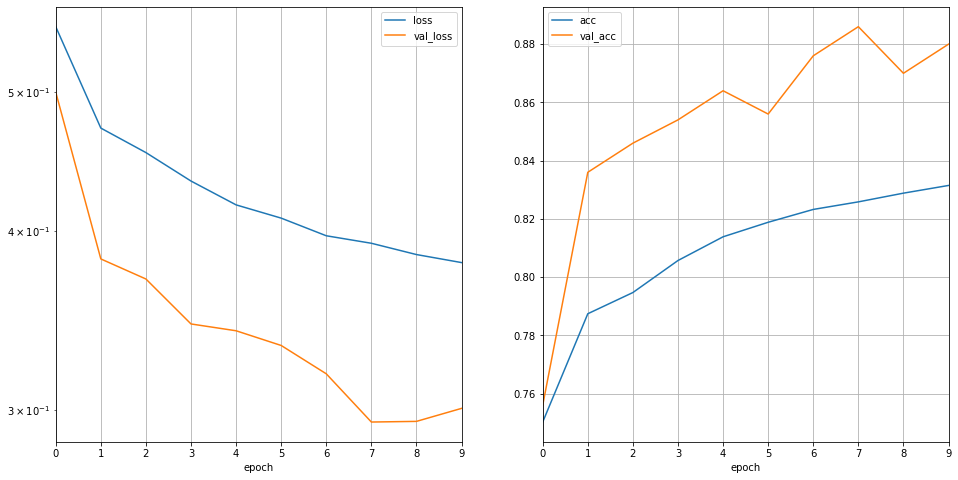

In [13]:
fig = plt.figure(figsize=(16, 8))
plot_history(history, metrics=['loss','acc'], val=True, logy=[True,False])

In [14]:
valid_generator_eval = valid_datagen.flow_from_directory(
        './test',
        target_size=input_shape,
        batch_size=50,
        class_mode='categorical',
        shuffle=False,
        seed=SEED)

Found 18474 images belonging to 3 classes.


In [15]:
y_pred = model.predict_generator(valid_generator_eval)
y_pred.shape

(18474, 3)

In [16]:
valid_generator_eval.batch_size = valid_generator_eval.samples
y_valid = valid_generator_eval.next()[1]

In [17]:
y_valid.shape

(18474, 3)

In [18]:
y_pred.argmax(axis=1)

array([0, 0, 0, ..., 0, 1, 1])

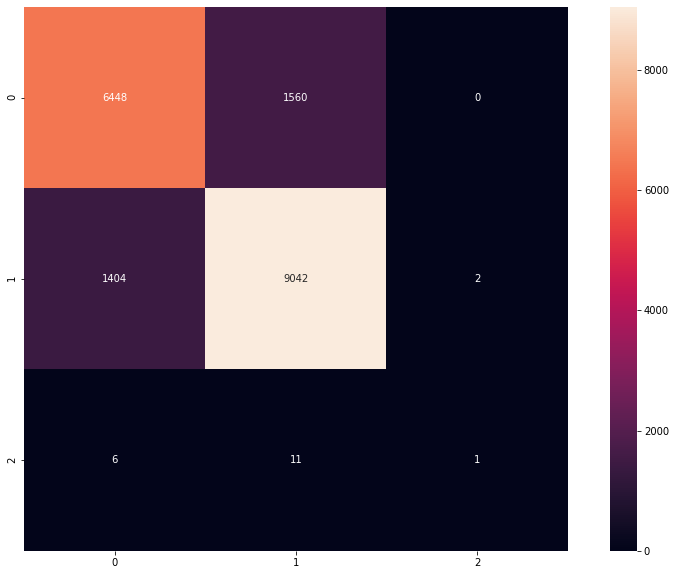

Accuracy= 0.8385298257009852


In [19]:
y_valid_class = y_valid.argmax(axis=1)
y_valid_pred_class = y_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_valid_class, y_valid_pred_class)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print('Accuracy=', accuracy_score(y_valid_class, y_valid_pred_class))